# Sentiment analysis on restaurant reviews with NLTK and TextBlob

<ins>Date Created/ Submitted: 25 Feb 19</ins>

For this capstone project, the aim is to predict the sentiment of a review using sentiment analysis. And, apply topic modelling using LDA or similar analysis to identify key topics/ area within each sentiment class (e.g. which topics/areas garner mostly negative reviews and which topic/areas garner mostly postive reviews).

This python implementation of this project is split into several python notebooks.
* Part 1: Web-scraping review data (The code for this is not uploaded to github)
* Part 2: Explore the data
* Part 3: Prepare the data (pre-processing)
* Part 4a: Modelling using word vector generated from CountVectorizer
* Part 4b: Modelling using word vector generated from TDIDFVectorizer
* Part 5: Summary Results with Topics Identified

### Part 4b: Modelling using word vector generated from TFIDFVectorizer

Modelling was performed on word vector generated from TFIDFVectorizer including using Logistic Regression, Support Vector Classifier, Decision Tree Classifier, Random Forest Classifier and Multinomial Naive Bayes. 

Note: Output of some cells have been cleared to desensitize the source of the web-scraping.

### Setting Up the Environment

In [1]:
## import various nlp packages
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from nltk import FreqDist
import contractions
import unicodedata

import gensim
from gensim import corpora 

import spacy

from textblob import TextBlob

import csv
import random
import re
import string
import time
from pprint import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set seed for replicability.
seedno = 18704
np.random.seed(seedno)

# to facilitate viewing full text
pd.set_option('display.max_colwidth', 120)
#pd.options.display.html.use_mathjax = False

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def plot_bars(attribute,setpalette='Spectral',setrotation=0,showlabels=True,sortvalue='ascending',sortcount=None):
    sns.set(style="whitegrid")
# Store frequency counts of each label where unique is the label and counts is its frequency
    unique, counts = np.unique(attribute.astype(str), return_counts=True)
    unique_counts = pd.DataFrame({'Value': unique, 'Count': counts})
    if sortvalue == 'descending':
        unique_counts = unique_counts.sort_values('Value', ascending=False)
    if sortvalue == 'ascending':
        unique_counts = unique_counts.sort_values('Value', ascending=True)
    if sortcount == 'descending':
        unique_counts = unique_counts.sort_values('Count', ascending=False)
    if sortcount == 'ascending':
        unique_counts = unique_counts.sort_values('Count', ascending=True)

# plot frequency counts
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.barplot(x="Value", y="Count", data=unique_counts,palette=setpalette)
    if showlabels==True:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height),
            ha="center") 
    plt.setp(ax.get_xticklabels(), rotation=setrotation)
    plt.show()

### Restaurant Reviews
### Read in files (from directory) for analysis 

In [3]:
rreviews = pd.read_csv('rreviews.csv')
rreviews = rreviews.drop(['Unnamed: 0'], axis=1)

In [4]:
rreviews.shape

(451065, 22)

In [5]:
# change date columns from string to date type. even though data preparation
# was performed in restaurantPreparation.ipynb, because the results was 
# exported to csv, it is necessary to re-define date format
import datetime
date_format = '%Y/%m/%d'
rreviews['review_date'] = pd.to_datetime(rreviews['review_date'])
rreviews['experience_date'] = pd.to_datetime(rreviews['experience_date'])

In [ ]:
# display first two document text
display(rreviews.head(2))

### Text (Review) Preprocessing Steps 

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import pos_tag_sents

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alphaniang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
#replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
lemma = WordNetLemmatizer()
stopwords_list = stopwords.words('english')

In [9]:
#define a new function clean that returns cleaned doc.
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', \
                    'ignore').decode('utf-8', 'ignore')
    return text

def clean(doc):
    fix_accent=remove_accented_chars(doc)
    tagged_words=[]
    for sent in pos_tag_sents(map(word_tokenize, sent_tokenize(fix_accent))):
        tagged_words += sent
    normalized = ' '.join(lemma.lemmatize(str(word).lower(), \
                    get_wordnet_pos(pos)) for word, pos in tagged_words) 
    fix_contractions=contractions.fix(normalized)
    fix_repeats=re.sub(r'(.)\1{2,}', r'\1\1', fix_contractions)
    keep_alpha=re.sub('[^a-z]+', ' ', fix_repeats)
    min_len_three = ' '.join([i for i in keep_alpha.split() \
                    if (len(i)>2 and i!='no')])
    stop_free = ' '.join([i for i in min_len_three.split() \
                    if i not in stopwords_list])
    return stop_free

def clean_bypos(doc, filtered_pos='N'):
    fix_accent=remove_accented_chars(doc)
    tagged_words=[]
    for sent in pos_tag_sents(map(word_tokenize, sent_tokenize(fix_accent))):
        tagged_words += sent

    if filtered_pos=='all':
        normalized = ' '.join(lemma.lemmatize(str(word).lower(), \
                    get_wordnet_pos(pos)) for word, pos in tagged_words) 
    
    elif filtered_pos!='all':
        if filtered_pos=='N':
            filtered_pos = ['NN', 'NNS', 'NNP', 'NNPS']
        elif filtered_pos=='J':
            filtered_pos = ['JJ', 'JJR', 'JJS']
        elif filtered_pos=='R':
            filtered_pos = ['RB', 'RBR', 'RBS']
        elif filtered_pos=='V':
            filtered_pos = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
        elif filtered_pos=='JV':
            filtered_pos = ['JJ', 'JJR', 'JJS','VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
        
        normalized = ' '.join(lemma.lemmatize(str(word).lower(), \
                    get_wordnet_pos(pos)) for word, pos in tagged_words if pos in filtered_pos) 
    
    fix_contractions=contractions.fix(normalized)
    fix_repeats=re.sub(r'(.)\1{2,}', r'\1\1', fix_contractions)
    keep_alpha=re.sub('[^a-z]+', ' ', fix_repeats)
    min_len_three = ' '.join([i for i in keep_alpha.split() if (len(i)>2 and i!='no')])
    stop_free = ' '.join([i for i in min_len_three.split() \
                    if i not in stopwords_list])
    return stop_free

### Classifying Review Sentiment

### Sentiment Polarity

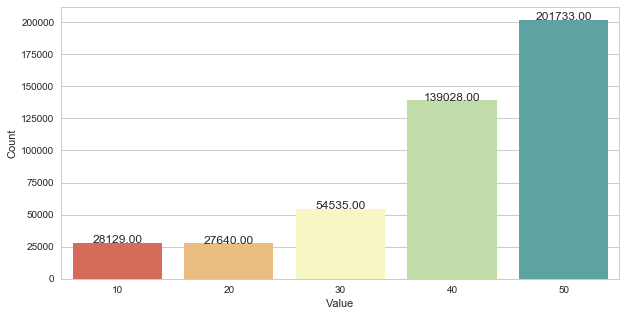

In [10]:
plot_bars(rreviews['rating'])

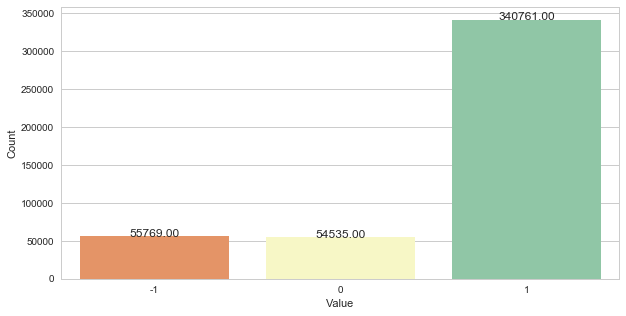

In [11]:
plot_bars(rreviews['rating_polarity'])

In [12]:
rreviews_polarity = rreviews[rreviews.rating_polarity != 0]

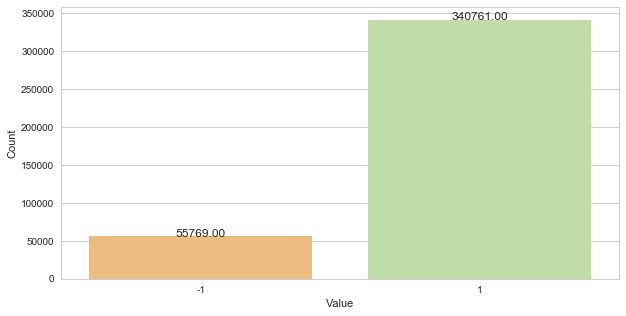

In [13]:
plot_bars(rreviews_polarity['rating_polarity'])

In [14]:
len(rreviews_polarity)

396530

### Train Test Split

In [15]:
# separate the features from the label. For X - drop labels, unnecessary attributes. 
# remaining attributes are review_date, word_count, char_count, avg_word_len,
# stop_perword, punc_perchar, alpha_perchar, numeric_count, upper_perchar, user_islocal
rreviews_X = rreviews_polarity.drop(['type','id','review_id','rating','review_date',\
                                     'experience_date','contributions','helpful_vote',\
                                     'user_id','user_name'], axis=1) 
rreviews_y = rreviews_polarity['rating_polarity'].copy()

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rreviews_X, rreviews_y,\
                                train_size=0.80, test_size=0.20, random_state=seedno)

In [17]:
#Check total count match
len(X_train)+len(X_test)

396530

### Create the Word Matrix

### TF-IDF Vectorizer

In [18]:
# we also try the tfidf vectorizer function (w the clean function as defined prior) 
from sklearn.feature_extraction.text import TfidfVectorizer
xtrain_tvec = TfidfVectorizer(preprocessor=clean,min_df=0.0001)

In [19]:
# we fit a word matrix based on the review text
xtrain_tvec.fit(X_train['review_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=0.0001,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function clean at 0x1a22720c80>, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [20]:
# we create a word matrix based on the review text
xtrain_tvec_matrix = xtrain_tvec.transform(X_train['review_text'])

In [21]:
print(xtrain_tvec.get_feature_names())

['aback', 'abalone', 'abandon', 'abba', 'abd', 'abhi', 'ability', 'abit', 'able', 'abode', 'abound', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absolute', 'absolutely', 'absolutley', 'absolutly', 'absorb', 'absurd', 'abundance', 'abundant', 'abuse', 'abusive', 'abuzz', 'abysmal', 'acai', 'accent', 'accentuate', 'accept', 'acceptable', 'access', 'accessible', 'accident', 'accidentally', 'accidently', 'acclaim', 'accolade', 'accommodate', 'accommodated', 'accommodating', 'accommodation', 'accomodate', 'accomodated', 'accomodating', 'accomodation', 'accompaniment', 'accompany', 'accompanying', 'accomplish', 'accor', 'accord', 'accordingly', 'account', 'accross', 'accurate', 'accurately', 'accuse', 'accustom', 'ace', 'ache', 'achieve', 'achievement', 'acid', 'acidic', 'acidity', 'acknowledge', 'acknowledgement', 'acknowledgment', 'acme', 'acoustic', 'acquaintance', 'acquire', 'acre', 'across', 'act', 'action', 'active', 'actively', 'activity', 'actual', 'actually', 'adam', 'adap

In [22]:
len(xtrain_tvec.get_feature_names())

9689

In [23]:
xtest_tvec_matrix = xtrain_tvec.transform(X_test['review_text'])

### Model Selection

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

### 1. Logistic Regression

In [25]:
lrt_starttime=time.time()
lrt = LogisticRegression()
lrt.fit(xtrain_tvec_matrix, y_train)
y_pred_lrt=lrt.predict(xtest_tvec_matrix)
lrt_runtime=time.time()-lrt_starttime

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
display(accuracy_score(y_test, y_pred_lrt))
display(precision_score(y_test, y_pred_lrt))
display(recall_score(y_test, y_pred_lrt))
display(f1_score(y_test, y_pred_lrt))
display(roc_auc_score(y_test, y_pred_lrt))
display(lrt_runtime)

0.97812271454871

0.9831261748291489

0.9915204420539047

0.9873054663320481

0.9443392618795278

5.145198822021484

### 2. SVC

In [27]:
svct_starttime=time.time()
svct = SVC()
svct.fit(xtrain_tvec_matrix, y_train)
y_pred_svct=svct.predict(xtest_tvec_matrix)
svct_runtime=time.time()-svct_starttime

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [28]:
display(accuracy_score(y_test, y_pred_svct))
display(precision_score(y_test, y_pred_svct))
display(recall_score(y_test, y_pred_svct))
display(f1_score(y_test, y_pred_svct))
display(roc_auc_score(y_test, y_pred_svct))
display(svct_runtime)

0.8580183088290924

0.8580183088290924

1.0

0.9235843422552799

0.5

22726.683270931244

### 3. Decision Tree Classifier

In [39]:
dtct_starttime=time.time()
dtct = DecisionTreeClassifier()
dtct.fit(xtrain_tvec_matrix, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
y_pred_dtct=dtct.predict(xtest_tvec_matrix)
dtct_runtime=time.time()-dtct_starttime

In [41]:
display(accuracy_score(y_test, y_pred_dtct))
display(precision_score(y_test, y_pred_dtct))
display(recall_score(y_test, y_pred_dtct))
display(f1_score(y_test, y_pred_dtct))
display(roc_auc_score(y_test, y_pred_dtct))
display(dtct_runtime)

0.9308122966736438

0.9567750697294061

0.9628633571407578

0.9598095586888848

0.8499929574336116

700.5817368030548

### 4. Random Forest Classifier

In [42]:
rfct_starttime=time.time()
rfct = RandomForestClassifier()
rfct.fit(xtrain_tvec_matrix, y_train)
y_pred_rfct=rfct.predict(xtest_tvec_matrix)
rfct_runtime=time.time()-rfct_starttime

/Users/alphaniang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [43]:
display(accuracy_score(y_test, y_pred_rfct))
display(precision_score(y_test, y_pred_rfct))
display(recall_score(y_test, y_pred_rfct))
display(f1_score(y_test, y_pred_rfct))
display(roc_auc_score(y_test, y_pred_rfct))
display(rfct_runtime)

0.9518069250750258

0.9618836660721477

0.9827763571701496

0.9722177800392527

0.8737149991889825

123.79702925682068

### 5. Multinomial Naive Bayes

In [44]:
mnbt_starttime=time.time()
mnbt = MultinomialNB()
mnbt.fit(xtrain_tvec_matrix, y_train)
y_pred_mnbt=mnbt.predict(xtest_tvec_matrix)
mnbt_runtime=time.time()-mnbt_starttime

In [45]:
display(accuracy_score(y_test, y_pred_mnbt))
display(precision_score(y_test, y_pred_mnbt))
display(recall_score(y_test, y_pred_mnbt))
display(f1_score(y_test, y_pred_mnbt))
display(roc_auc_score(y_test, y_pred_mnbt))
display(mnbt_runtime)

0.9591203692028346

0.9591339341381852

0.9947388531287659

0.9766119840136201

0.8693054834027488

0.126723051071167